<a href="https://colab.research.google.com/github/gabdele/ABC/blob/main/assignment1_gld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1: Loading Data

## Instructions

Please follow the [instructions](assignments-setup.qmd) for setting up, completing, and submitting your assignments.

## Assignment Overview

The focus of this first assignment is on the process of loading and preparing image data to be fed to a neural network. This is the first step in developing a modeling pipeline.

**After completing this assignment, you will learn how to load, manage, and visualize image data in PyTorch, with a focus on remote sensing workflows.**

In this assignment, you will practice:

- Loading the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset [contained within PyTorch](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST), using PyTorch utilities. This is not a remote sensing dataset, but it is a good first image dataset that is useful for learning models, and provides familiarity with using packaged datasets, such as those in [`torchgeo`](https://torchgeo.readthedocs.io/en/stable/api/datasets.html)

- Loading a set of provided Planet image chips and their corresponding labels (from a [dataset made publicly available](https://registry.opendata.aws/africa-field-boundary-labels/) by the [Mapping Africa project](https://github.com/agroimpacts/ftw-mappingafrica-integration)), such that the data are:

  - Actively loaded;

  - Augmented on-the-fly;

  - Split intro training/test partitions on-the-fly;

  - Normalized inside the dataloader;

You will also practice reading in each image/label pair:

  - Using [`rasterio`](https://rasterio.readthedocs.io/en/stable/), as is commonly done with remote sensing data;

  - From a csv catalog;

  - From a directory

**Visualization Task**

Using the dataloader you develop, you will:

- Load and visualize the corresponding:

  - Image (satellite raster)

  - Label / mask

## Assignment

Follow the instructions below to complete your coding assignment.

Run the code in the sections beginning with "Static" unchanged, unless otherwise indicated.

### Static code 1

In [2]:
# @title Mount drive and run imports
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
# @title Importing Necessary Packages

# import torchvision.transforms as transforms
from torchvision.transforms import v2
import torchvision.datasets as datasets
import torch.utils.data as data
import copy

import matplotlib.pyplot as plt
import cv2
import numpy as np
import random
import numbers
import torch

import pandas as pd
import os

from pathlib import Path

from torch.utils.data import Dataset, DataLoader
import rasterio

# function to ensure reproducibility by fixing random state
def set_seed(seed_value):
    """Set seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(1)

In [4]:
# @title Save path

# Modify 'save_dir' to the path to download MNIST dataset.
save_dir = "your_directory"

### Task 1
#### **Load, transform, and normalize MINST data (Steps 1.1-1.4)**

In this task, you will develop functions that will:

1) Apply some additional processing steps to the imagery, including two image transformations (random rotation of images and randomly cropping images), convertion of images to tensors, and normalizing the imagery.

2) Load in the built-in MNIST datasets using functions that apply those image processing steps, making separate loaders for three splits: 1) train, 2) validation, and 3) test.

3) Make each of the three data loaders iterable;

4) Visualize a single digit from the dataset

Useful documentation and tutorials and tutorials that you should (read before coding):

[torchvision transforms documentation](https://pytorch.org/vision/stable/transforms.html)

Pay special attention to:

- `v2.Compose`
- `v2.RandomRotation` (use 5 degrees and a fill of 0)
- `v2.RandomCrop` (use a size of 28, and padding of 2)
- `v2.ToImage()` and `v2.ToDtype()`
- `v2.Normalize` (apply the mean and standard deviation provided above)

Note: We imported `transforms` V2, which is why the functions are pulled from the `v2` sub-module.  

Note: These values represent the mean and standard deviation of the MNIST dataset, which you will need for normalizing the data:

mnist_mean = 0.13066048920154572
mnist_std = 0.30810779333114624

In [5]:
mnist_mean = [0.13066048920154572]
mnist_std = [0.30810779333114624]

#### Step 1: Define processing pipeline

Use `v2.Compose` to develop a function that applies in the following order: `v2.RandomRotation`, `v2.RandomCrop`, `v2.ToImage()` followed by `v2.ToDtype(torch.float32, scale=True)`, then `transforms.Normalize`.

These functions will do the necessary preprocessings on train and test datasets. Name the functions `train_transforms`, and `test_transforms`.

You will only apply the rotation and crop within `train_transforms`. `test_transforms` only needs the image conversions type conversions and normalization.


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
## Answer here (5 points)
def train_transforms(content):
  transforms = v2.Compose([
      v2.RandomRotation(5, fill = 4),
      v2.RandomCrop(28, 2),
      v2.ToImage(),
      v2.ToDtype(torch.float32, scale=True),
      v2.Normalize(mnist_mean, mnist_std)
  ])
  # transforms.Normalize(mnist_mean, mnist_std)

  return(transforms(content))

def test_transforms(content):
  transforms = v2.Compose([
      v2.ToImage(),
      v2.ToDtype(torch.float32, scale=True),
      v2.Normalize(mnist_mean, mnist_std)
  ])
  # transforms.Normalize(mnist_mean, mnist_std)

  return(transforms(content))



#### Step 2: Load in the MNIST data and apply transforms

Using `datasets.MNIST`, `data.random_split`, and a ratio of 90% to split the train set into `train` and `validation` (you should know what's the differences between test and validation data--if not, please ask).

First, you are going to `datasets.MNIST` to create `train_data` and `test_data` objects, in which you use the transform argument to pass in your different transform function to each dataset. Choose to download the data, and the train argument will specify which MNIST data pool (train or test) the data is drawn from.  



Second, you will then split the train dataset into train and validation sets. Use length of the `train_data` object and the split ratio (0.9) to determine how many samples are for train (90% of total) and how many for validate (10%) of total.

You will then apply `data.random_split` to `train_data` to pull out an updated `train_data` split, and then new `validate_data` split. Because validation data should not have transformations applied to them (rotate, crop), you will overwrite the transformation on the `validation.data.transform` with the `test_transform` function.

To do this, first **note** that `random_split` does not create independent datasets. It creates subsets that share the same underlying dataset object. Because of this, if you change the transform of the validation subset without making a copy, the training subset will also be affected.

Using `copy.deepcopy` ensures that the validation data can use different transforms (no augmentation) without altering the training data. So make a deep copy of `validate_data` first before over-writing the transformation.

In [8]:
## Answer here (5 points)
train_data = datasets.MNIST(
    root = "./",
    train = True,
    download = True,
    transform = train_transforms)

test_data = datasets.MNIST(
    root = "./",
    train = False,
    download = True,
    transform = test_transforms
)

train_count = int(0.9 * len(train_data))
test_count = int(len(train_data) - train_count)


train_data, validate_data = data.random_split(
    train_data, [train_count, test_count]
    )
validate_data = copy.deepcopy(validate_data)
validate_data.dataset.transform = test_transforms


100%|██████████| 9.91M/9.91M [00:00<00:00, 40.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.18MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.21MB/s]


Check: After you have made the three datasets, you should get the following results from these functions:



In [9]:
print(train_data.dataset); print(validate_data.dataset); print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: <function train_transforms at 0x7cd01a9262a0>
Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: <function train_transforms at 0x7cd01a9262a0>
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./
    Split: Test
    StandardTransform
Transform: <function test_transforms at 0x7cd01a926520>


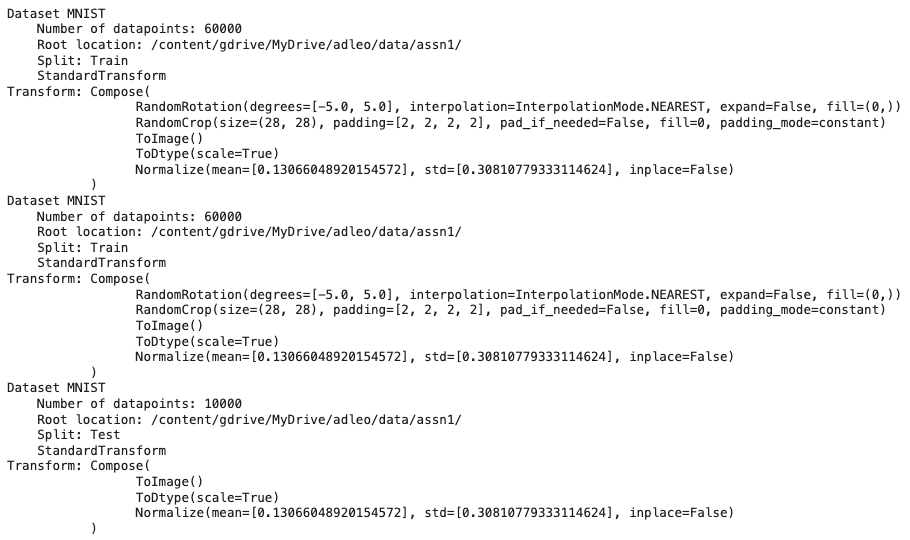

#### Step 3: Make data loaders

Use `data.DataLoader` to make an iterable `train_loader`, `validation_loader`, and `test_loader`.

We want to make a batch size of 50, and apply shuffle to the `train_loader`but not `validation_loader` and `test_loader`

Note: when doing this, use the function `set_seed(1)` when doing so, placed before the code that sets up your loaders, e.g.    

```python
set_seed(1)
# the code you are running starts here
```
This allows us to all get the same results, and helps you know whether your code is performing as it should.

In [10]:
## Answer here (5 points)
set_seed(1)
train_loader = data.DataLoader(
    train_data,
    batch_size = 50,
    shuffle = True
)

validation_loader = data.DataLoader(
    validate_data,
    batch_size = 50,
    shuffle = False
)

test_loader = data.DataLoader(
    test_data,
    batch_size = 50,
    shuffle = False
)


Check: You should see the results below when running the following code.

In [11]:
print(test_loader.dataset.data[0][5:10, 5:10])
print(train_loader.dataset.dataset.data[0][5:10, 5:10])
print(validation_loader.dataset.dataset.data[0][5:10, 5:10])


tensor([[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,  84, 185, 159, 151],
        [  0, 222, 254, 254, 254],
        [  0,  67, 114,  72, 114]], dtype=torch.uint8)
tensor([[  0,   0,   0,   0,   0],
        [  0,   0,   0,  30,  36],
        [  0,   0,  49, 238, 253],
        [  0,   0,  18, 219, 253],
        [  0,   0,   0,  80, 156]], dtype=torch.uint8)
tensor([[  0,   0,   0,   0,   0],
        [  0,   0,   0,  30,  36],
        [  0,   0,  49, 238, 253],
        [  0,   0,  18, 219, 253],
        [  0,   0,   0,  80, 156]], dtype=torch.uint8)


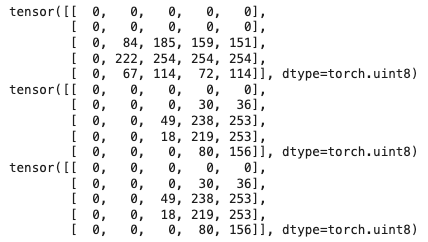

#### Step 4: Visualize one of the images

Use matplotlib.pyplot to visualize the "second" item in the batch of image and corresponding label (e.g., `idx = 1`).

You are going to use `iter` and `next` to extract the images and labels from batch of the `train_loader`.

Use the correct index for getting the second image and label out of the batch. Note the image will have to be `squeeze`d to strip out its channel dimension. The label is just a number.

When plotting use a gray scale cmap. The label value can be placed as a title on top of the plot.

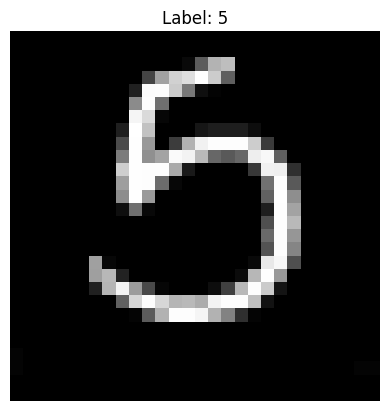

In [12]:
## Answer here (5 points)
images, labels = next(iter(train_loader))

idx = 1
image = images[idx]
label = labels[idx]

plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

Check: you should see the following image when you display the extracted image.

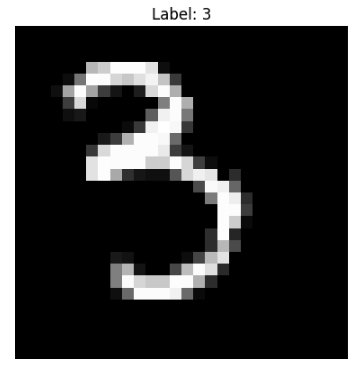

### Task 2
#### **Working with a custom, EO dataset in `PyTorch` (Steps 2.1-2.4)**

In this section, you are provided with some existing EO data, which  consists of Planet image chips (a subset of a larger image prepared to standard dimensions suitable for feeding to a convolutional neural network, in this case 256x246 pixels) collected over Africa with 4 bands (RGB and NIR). Each chip is also accompanied by an annotation layer in the form of a mask that shows non-crop as 0, crop field interior as 1 and field boundaries as 2 (e.g. label folder).

Please do the following:

- Download the [input data located on Google Drive](https://drive.google.com/drive/folders/11sdCgNpLtAy9YZrDCCGsNqglRX-mwV0f?usp=drive_link) and transfer it your own Google Drive

- Compile the provided code for input normalization and two common image augmentation tasks (rotation and flipping).

For the purpose of this assignment, we will focus on developing an active and lazy data loading strategy. Your job is to modify the `ActiveLoadingDataset()` class to do the following:

- Read your input image, label and mask;
- Apply image normalization (either min/max or z-score);
- Apply on-the-fly augmentation on your image, label, or both depending on your choice of augmentation.
    - For this assignment you only need to add the two provided augmentations.
    - Note that using flip is a bit tricky as it has two options and you want the code to be flexible to choose either horizontal (hflip) or vertical (vflip)randomly chosen in each epoch.
- Adapt the incomplete `ActiveLoadingDataset()` class provided for you, where indicated, so that the completed code, upon calling, successfully creates your training (with augmentations applied) and validation datasets when reading from:
    - a CSV catalog
    - Directly out of the label folders, and at the same time creates the training and validation splits on the fly.

#### Static code 2

In [13]:
#@title Input normalization
def min_max_normalize_image(image, dtype=np.float32):
    """
    image_path(str) -- Absolute path to the image patch.
    dtype (numpy datatype) -- data type of the normalized image default is
    "np.float32".
    """

    # Calculate the minimum and maximum values for each band
    min_values = np.nanmin(image, axis=(1, 2))[:, np.newaxis, np.newaxis]
    max_values = np.nanmax(image, axis=(1, 2))[:, np.newaxis, np.newaxis]

    # Normalize the image data to the range [0, 1]
    normalized_img = (image - min_values) / (max_values - min_values)
    # normalized_img = normalized_img.astype(dtype)

    # Return the normalized image data
    return normalized_img

#### Image augmentation
Two functions for augmentation are included in the static code here. You can choose from these, or include others from the main assignment instead (e.g. translation, blur, gamma). If you do choose to add others, please add the functions into the chunks where indicated below in Coding Task section below.

In [14]:
#@title Rotation transformation (`cv2`)
def rotate_image_and_label(image, label, angle):
    """
    Applies rotation augmentation to an image patch and label.

    Args:
        image (numpy array) : The input image patch as a numpy array.
        label (numpy array) : The corresponding label as a numpy array.
        angle (lost of floats) : If the list has exactly two elements they will
            be considered the lower and upper bounds for the rotation angle
            (in degrees) respectively. If number of elements are bigger than 2,
            then one value is chosen randomly as the roatation angle.

    Returns:
        A tuple containing the rotated image patch and label as numpy arrays.
    """
    if isinstance(angle, tuple) or isinstance(angle, list):
        if len(angle) == 2:
            rotation_degree = random.uniform(angle[0], angle[1])
        elif len(angle) > 2:
            rotation_degree = random.choice(angle)
        else:
            raise ValueError("Parameter degree needs at least two elements.")
    else:
        raise ValueError(
            "Rotation bound param for augmentation must be a tuple or list."
        )

    # Define the center of the image patch
    center = tuple(np.array(label.shape)/2.0)

    # Define the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, rotation_degree, 1.0)

    # Apply rotation augmentation to the image patch
    rotated_image = cv2.warpAffine(image, rotation_matrix, image.shape[:2],
                                   flags=cv2.INTER_LINEAR)

    # Apply rotation augmentation to the label
    rotated_label = cv2.warpAffine(label, rotation_matrix, label.shape[:2],
                                   flags=cv2.INTER_NEAREST)

    # Return the rotated image patch and label as a tuple
    return rotated_image.copy(), np.rint(rotated_label.copy())

In [15]:
#@title Image flipping (`cv2`)
def flip_image_and_label(image, label, flip_type):
    """
    Applies horizontal or vertical flip augmentation to an image patch and label

    Args:
        image (numpy array) : The input image patch as a numpy array.
        label (numpy array) : The corresponding label as a numpy array.
        flip_type (string) : Based on the direction of flip. Can be either
            'hflip' or 'vflip'.

    Returns:
        A tuple containing the flipped image patch and label as numpy arrays.
    """
    if flip_type == 'hflip':
        # Apply horizontal flip augmentation to the image patch
        flipped_image = cv2.flip(image, 1)

        # Apply horizontal flip augmentation to the label
        flipped_label = cv2.flip(label, 1)

    elif flip_type == 'vflip':
        # Apply vertical flip augmentation to the image patch
        flipped_image = cv2.flip(image, 0)

        # Apply vertical flip augmentation to the label
        flipped_label = cv2.flip(label, 0)

    else:
        raise ValueError("Flip direction must be 'horizontal' or 'vertical'.")

    # Return the flipped image patch and label as a tuple
    return flipped_image.copy(), flipped_label.copy()

In [16]:
#@title Plot random pairs from the Pytorch customDataset object.
def show_random_pairs(dataset, sample_num, rgb_bands):
    # basic checks
    if not (isinstance(sample_num, int) and 1 <= sample_num <= len(dataset)):
        raise ValueError("sample_num must be between 1 and len(dataset).")

    if not (isinstance(rgb_bands, (tuple, list)) and len(rgb_bands) == 3):
        raise ValueError("rgb_bands must be a tuple/list of length 3.")

    r, g, b = rgb_bands
    nrow, ncol = sample_num, 2

    fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(16, 6 * nrow),
                            squeeze=False)

    sample_indices = random.sample(range(len(dataset)), k=sample_num)

    for i, idx in enumerate(sample_indices):
        x, y = dataset[idx]          # x: (C,H,W), y: (H,W)
        x = x.cpu()
        y = y.cpu()

        # build RGB (H,W,3)
        rgb = torch.stack([x[r], x[g], x[b]], dim=0).permute(1, 2, 0)

        # if values look like 0..1 keep as float; otherwise scale for display
        if (rgb.max() - rgb.min()) > 1:
            rgb = rgb.int()

        axs[i, 0].set_title(f"Image #{idx}")
        axs[i, 0].imshow(rgb)
        axs[i, 0].axis("off")

        axs[i, 1].set_title(f"Label #{idx}")
        axs[i, 1].imshow(y)
        axs[i, 1].axis("off")

    plt.tight_layout()
    plt.show()


In [17]:
from rasterio.plot import reshape_as_image
try_raster = rasterio.open(
    "/content/drive/MyDrive/mappingafrica-256/images/AO0632385_2022-11.tif").read()
try_img = reshape_as_image(try_raster)
print(f"The dtype of the image is: {try_img.dtype}")

The dtype of the image is: uint16


#### Step 1: Modify directories

In [18]:
# Define the path to the catalog in Google Drive (shared with you).
# Modify it as needed to match your Drive structure.
# you may find it helpful to define a variable that contains the path root
# (src_dir)
src_dir =  "/content/drive/MyDrive/mappingafrica-256"
csv_path = f"{src_dir}/catalog.csv"
catalog = pd.read_csv(csv_path)
catalog.head()

name        dataset version country        x       y  fld_prop  \
0  AO0632385  mappingafrica  v2.0.0      AO  17.7865 -8.5125  0.098633   
1  AO0848301  mappingafrica  v2.0.0      AO  13.6515 -9.1375  0.232502   
2  AO0896141  mappingafrica  v2.0.0      AO  15.7365 -9.2725  0.525590   
3  AO1006914  mappingafrica  v2.0.0      AO  15.7365 -9.5925  0.024374   
4  AO1031101  mappingafrica  v2.0.0      AO  15.7515 -9.6625  0.962133   

   nonfld_prop  null_prop  window_a  \
0     0.901367        0.0       NaN   
1     0.767498        0.0       NaN   
2     0.474410        0.0       NaN   
3     0.975626        0.0       NaN   
4     0.037867        0.0       NaN   

                                         window_b  \
0  mappingafrica-256/images/AO0632385_2022-11.tif   
1  mappingafrica-256/images/AO0848301_2018-08.tif   
2  mappingafrica-256/images/AO0896141_2020-11.tif   
3  mappingafrica-256/images/AO1006914_2020-11.tif   
4  mappingafrica-256/images/AO1031101_2021-11.tif   

                                                mask  split  
0  mappingafrica-256/labels/AO0632385_13723_2022-...   test  
1  mappingafrica-256/labels/AO0848301_5032_2018-0...  train  
2  mappingafrica-256/labels/AO0896141_6106_2020-1...  train  
3  mappingafrica-256/labels/AO1006914_21105_2020-...  train  
4  mappingafrica-256/labels/AO1031101_26851_2021-...  train

#### Step 2: Adapt the template below to create your custom data loader.
**Note** we are reading the data from a catalog in here

In [19]:
## Answer here: Modify the requested parts (20 points)
from rasterio.plot import reshape_as_image

class ActiveLoadingDataset(Dataset):
    def __init__(self, src_dir, csv_path, split,
                 apply_normalization=True, transform=None, **kargs):
        r"""
        src_dir (str or path) : Root of resource directory.
        csv_path (str) : Directory of the csv file containing the input paths.
        split (str) : Either 'train' or 'validate'.
        transform (list) : Each element is string name of the transformation
            to be used, e.g. ["rotate", "flip"].
        """

        self.src_dir = src_dir
        self.csv_path = csv_path
        self.transform = transform
        self.apply_normalization = apply_normalization

        self.split = split
        assert self.split in ["train", "validate"], "Split is not recognized."

        # Load catalog and subset by split
        catalog = pd.read_csv(Path(self.csv_path))
        self.catalog = catalog[catalog.split == self.split].reset_index(drop=True)

        # Store paths (images are already chipped)
        self.img_paths = self.catalog["window_b"]
        self.lbl_paths = self.catalog["mask"]


    def __getitem__(self, index):

        # Load image chip
        # Make sure channel is last dimension (H, W, C)
        img_path = Path(self.img_paths.iloc[index])
        img_path = Path(*img_path.parts[1:])
        img_path = Path(self.src_dir)/img_path
        i_raster = rasterio.open(img_path).read()
        img = np.transpose(i_raster, (1, 2, 0))

        # Load label chip (H, W)
        lbl_path = Path(self.lbl_paths.iloc[index])
        lbl_path = Path(*lbl_path.parts[1:])
        lbl_path = Path(self.src_dir)/lbl_path
        label = rasterio.open(lbl_path).read(1)

        # Apply normalization if requested
        if self.apply_normalization:
            img = min_max_normalize_image(img, np.uint16)

        # Data augmentation (training only)
        if self.split == "train" and self.transform:

            # Add your augmentation logic here.
            # If applying flipping, randomly choose the flip direction.
            if random.randint(0, 1) and "rotate" in self.transform:
                img, label = rotate_image_and_label(img, label, [90, 180, 270])

            if random.random() > 0.5 and "flip" in self.transform:
                img, label = flip_image_and_label(img, label, "hflip")
            elif "flip" in self.transform:
                img, label = flip_image_and_label(img, label, "vflip")

        # Convert numpy arrays to torch tensors
        # Image must be CHW
        image_tensor = torch.from_numpy(
            img.transpose((2, 0, 1))
        ).float()

        #label = reshape_as_image(label)
        label_tensor = torch.from_numpy(
            np.ascontiguousarray(label)
        ).long()

        return image_tensor, label_tensor


    def __len__(self):
        # Return the number of samples in this split
        return  len(self.catalog)


#### Step 3: Demonstrate your loader

Use your modified `ActiveLoadingDataset` class to load the train_dataset, validate_dataset, then use `show_random_pairs` to visualize 2 of the image/label pairs.

Note: to ensure reproducibility, please place `set_seed(1)` before the code.

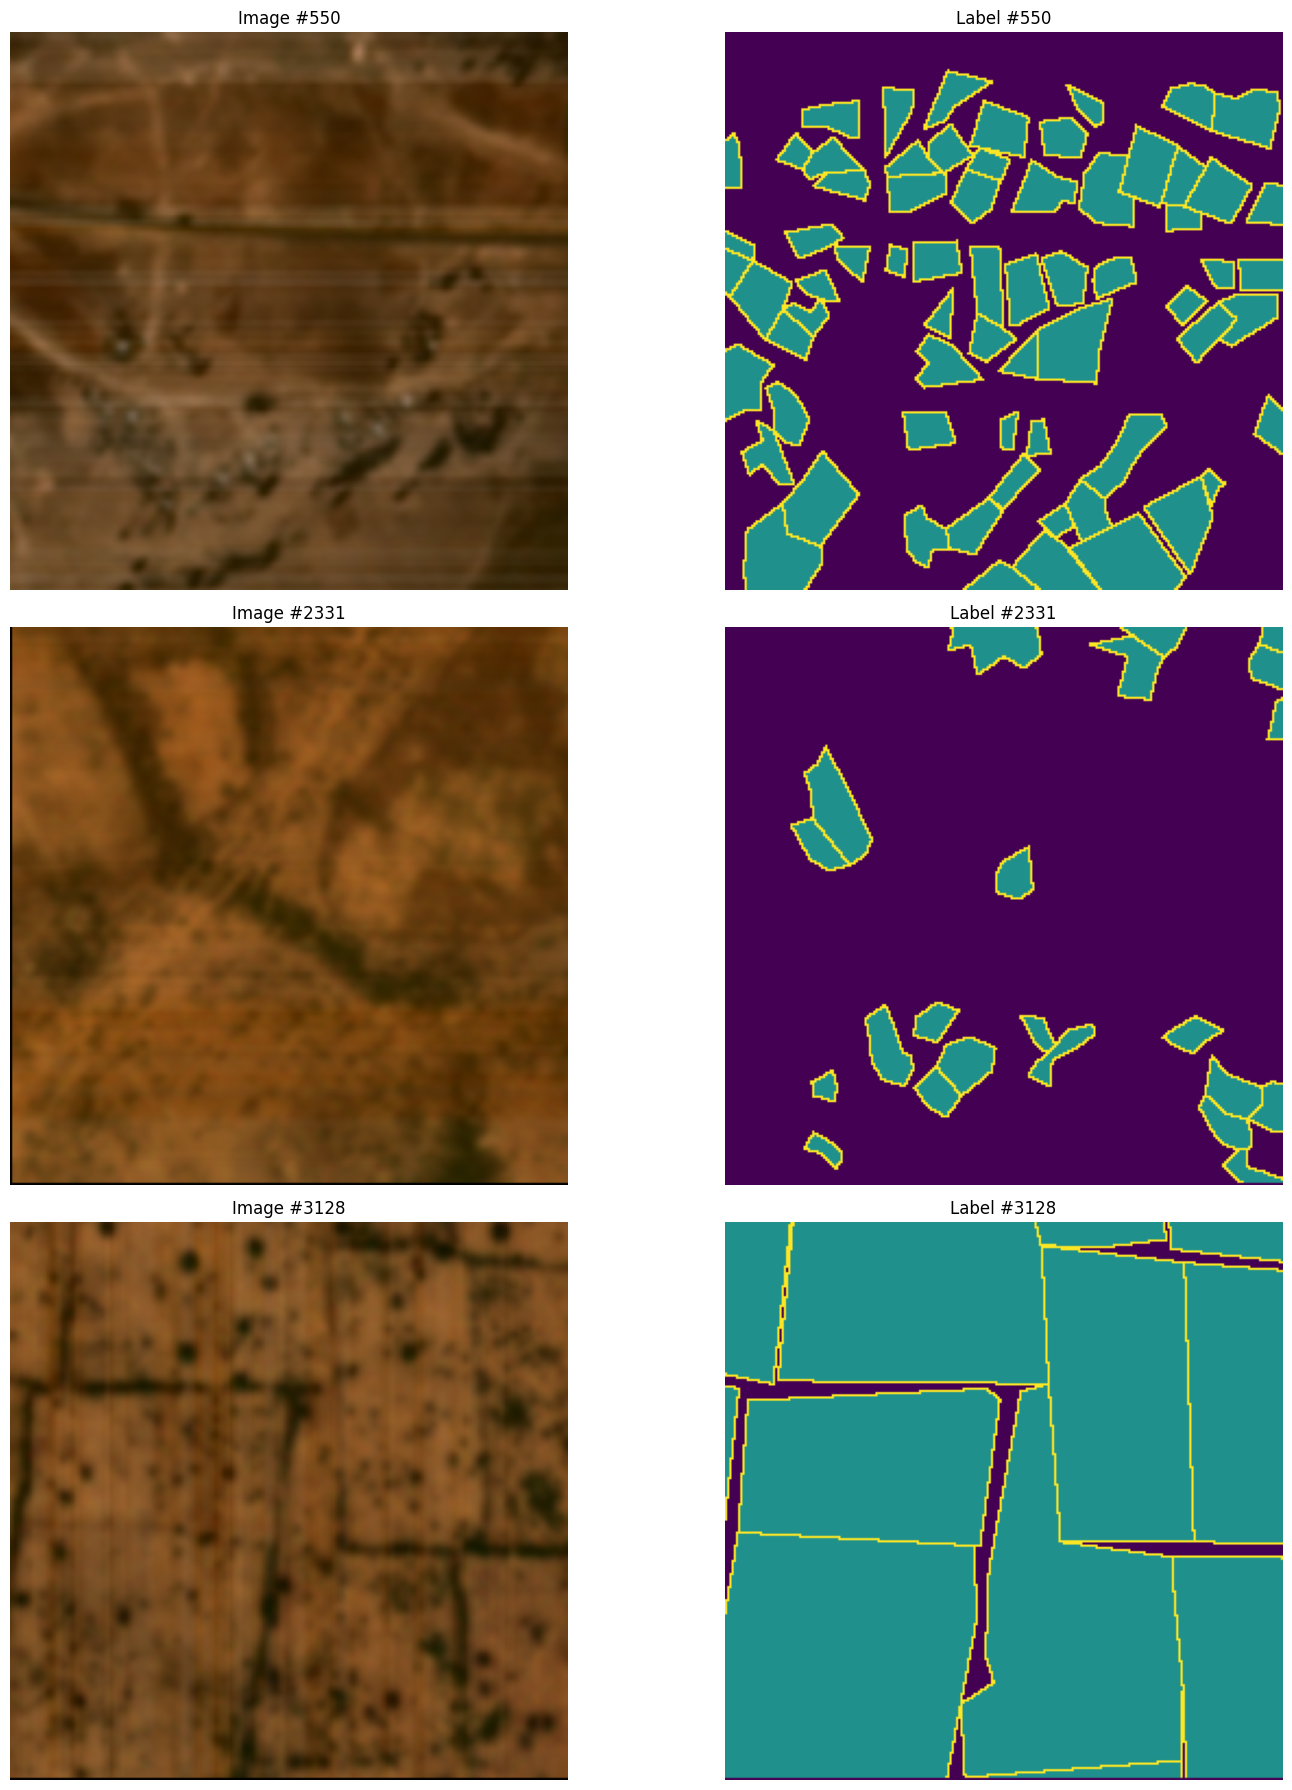

In [20]:
## Answer here (15 points)
set_seed(1)
training_a = ActiveLoadingDataset(
    src_dir, csv_path, "train", transform=["rotate", "flip"]
    )
validation_a = ActiveLoadingDataset(src_dir, csv_path, "validate")

show_random_pairs(training_a, int(3), [0,1,2])


Check: you should see the following images and labels when you display the extracted image.

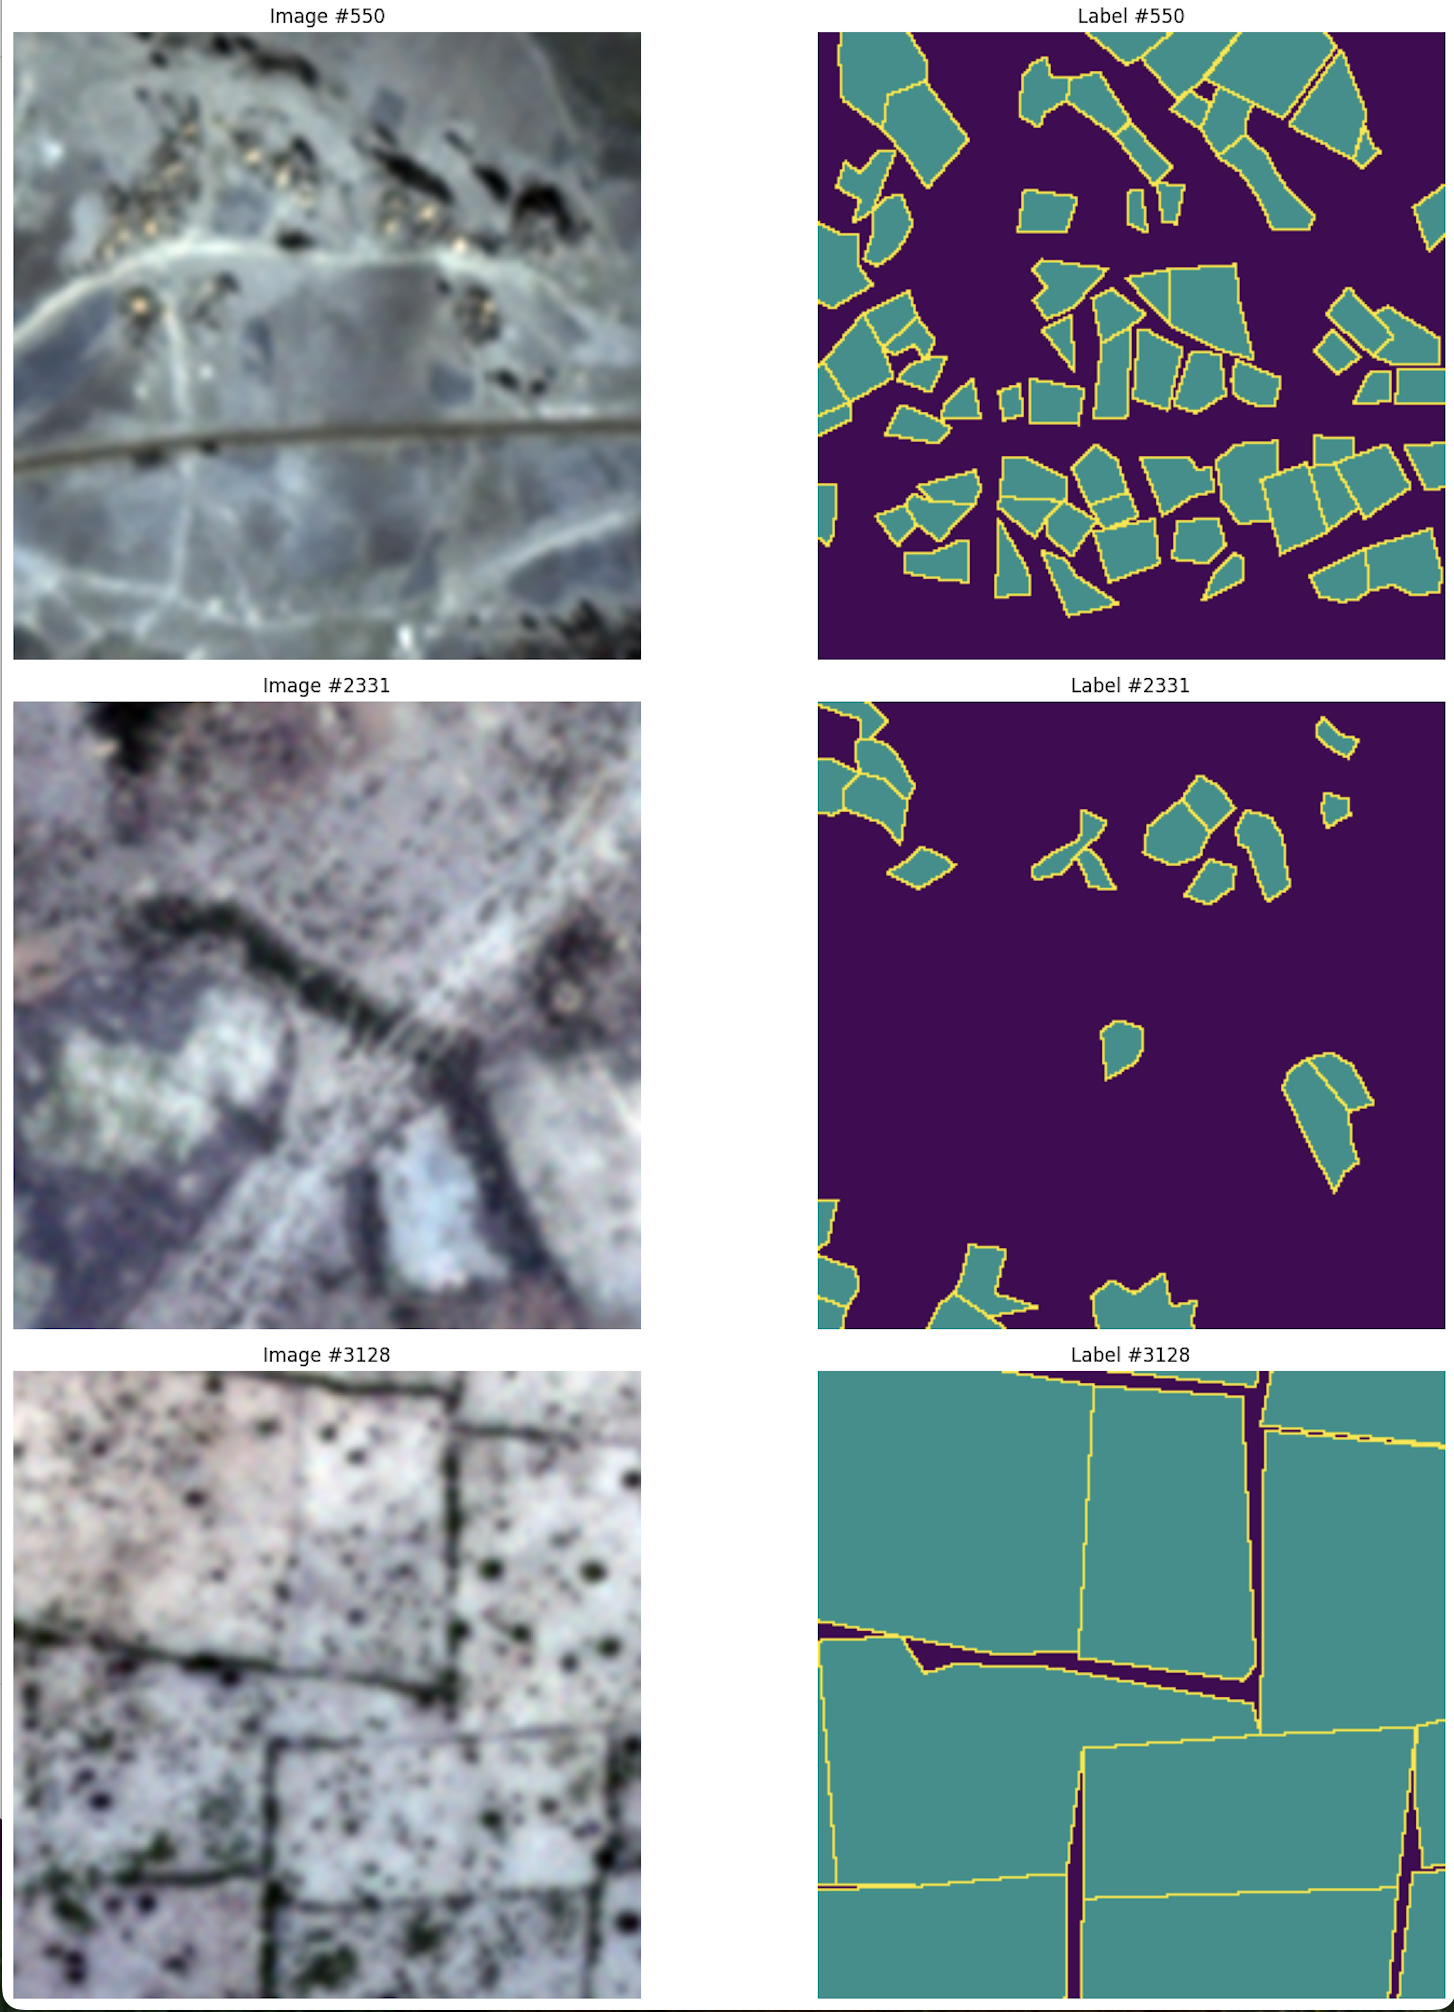

#### Step 4: Changing the dataloader style

Modify `ActiveLoadingDataset` to load train_dataset and validate_dataset, this time directly from the folder and do the train validate split on the fly (name the class ActiveLoadingDatasetDirect)

In [21]:
## Answer here (30 points)

class ActiveLoadingDatasetDirect(Dataset):
    """
    Directory-driven dataset for *already-chipped* remote sensing imagery.
    (No CSV. Train/validate split is created on-the-fly.)

    Dataset root (fixed):
        Path(src_dir) / "mappingafrica-256"

    Expects folders inside mappingafrica-256:
        images/   (image chips)
        labels/   (label/mask chips)

    Pairing rule (your filenames):
        image: AO0632385_2022-11.tif
        label: AO0632385_13723_2022-11.tif
      -> label has an extra token in the middle (e.g., 13723)
      -> match by (prefix, suffix) = (first token, last token) split by "_"

    Returns:
      image_tensor: float32, shape (C, H, W)
      label_tensor: int64,   shape (H, W)
    """

    def __init__(self, src_dir, split,
                 train_ratio=0.8, seed=42,
                 apply_normalization=True, transform=None,
                 image_suffix=".tif", label_suffix=".tif",
                 **kargs):

        # TODO 1: DIRECTORY ROOT (instead of CSV)
        # Set the dataset root

        self.src_dir = Path(src_dir) / "mappingafrica-256"

        self.transform = transform
        self.apply_normalization = apply_normalization

        self.split = split
        assert self.split in ["train", "validate"], "Split is not recognized."

        # TODO 2: READ FROM DIRECTORIES
        # Create paths for:
        #(note that in mappingafrica-256 folder there are 2 subfolders
        # named images and labels)
        img_dir = self.src_dir / "images"
        lbl_dir = self.src_dir / "labels"

        # Optional: raise helpful errors if folders don’t exist
        if not img_dir.exists(): raise FileNotFoundError(...)
        if not lbl_dir.exists(): raise FileNotFoundError(...)

        # Use Path.glob to collect all .tif files and sort them
        img_files = sorted(img_dir.glob(f"*{image_suffix}"))
        lbl_files = sorted(lbl_dir.glob(f"*{label_suffix}"))

        # TODO 3: PAIRING RULE (prefix + suffix)
        # Build a lookup dict for labels keyed by:
        #   key = (first_token, last_token)
        # where tokens come from: lp.stem.split("_")
        lbl_lookup = {}
        for lp in lbl_files:
            tokens = lp.stem.split("_")
            key = (tokens[0], tokens[-1])
            lbl_lookup[key] = lp

        # Build all_pairs = list of (image_path, label_path)
        all_pairs = []
        for ip in img_files:
          tokens = ip.stem.split("_")
            # 1) split ip.stem by "_"
            # 2) build key = (first_token, last_token)
          key = (tokens[0], tokens[-1])
            # 3) find matching label in lbl_lookup
            # 4) append to all_pairs if match exists
          if key in lbl_lookup:
              all_pairs.append((ip, lbl_lookup[key]))

        if len(all_pairs) == 0: raise ValueError("No pairs matched...")

        # TODO 4: TRAIN/VALIDATE SPLIT ON THE FLY
        # Use numpy RNG with a seed:
        rng = np.random.default_rng(seed)
        perm = rng.permutation(len(all_pairs))
        # then:
        n_train = int(len(all_pairs) * train_ratio)
        train_idx = perm[:n_train]
        valid_idx = perm[n_train:]
        # finally:
        #   self.pairs = the chosen pairs for this split
        if self.split == "train":
            self.pairs = [all_pairs[i] for i in train_idx]
        else:
            self.pairs = [all_pairs[i] for i in valid_idx]


        # NOTE: Use the SAME loading/normalization/augmentation
        # logic as the previous assignment.

        self.images = []
        self.labels = []
        for img_path, lbl_path in self.pairs:

            # Load image chip (same as previous task)
            i_raster = rasterio.open(img_path).read()
            img = np.transpose(i_raster, (1, 2, 0))

            # Load label chip (same as previous task)
            label = rasterio.open(lbl_path).read(1)

            # Apply normalization if requested (same as previous task)
            if self.apply_normalization:
                img = min_max_normalize_image(img, np.uint16)

            self.images.append(img)
            self.labels.append(label)


    def __getitem__(self, index):

        img = self.images[index].copy()
        label = self.labels[index].copy()

        # Data augmentation (training only) — same as previous task
        if self.split == "train" and self.transform:

            if random.randint(0, 1) and "rotate" in self.transform:
                img, label = rotate_image_and_label(img, label, angle=[90, 180, 270])

            if random.random() > 0.5 and "flip" in self.transform:
                flip_type = random.choice(["hflip", "vflip"])
                img, label = flip_image_and_label(img, label, flip_type)

        # Convert numpy arrays to torch tensors (same as previous task)
        image_tensor = torch.from_numpy(
            img.transpose((2, 0, 1))
        ).float()

        label_tensor = torch.from_numpy(
            np.ascontiguousarray(label)
        ).long()

        return image_tensor, label_tensor


    def __len__(self):
        # Return the number of samples in this split
        return  len(self.catalog)

#### Step 5: Demonstrate your loader

Use the `ActiveLoadingDatasetDirect` class to load train_dataset, validate_dataset, then use `show_random_pairs` to visualize 2 of the image/label pairs.

Note: to ensure reproducibility, please place `set_seed(1)` before the code.

In [22]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Answer here (15 points)
set_seed(1)
train_dataset = ActiveLoadingDatasetDirect(
    src_dir = "/content/gdrive/MyDrive",
    split = "train",
    transform = ["rotate", "flip"]
)

validate_dataset = ActiveLoadingDatasetDirect(
    src_dir = "/content/gdrive/MyDrive",
    split= "validate",
    transform = None
)

show_random_pairs(train_dataset, 2, rgb_bands=[0, 1, 2])

Check: you should see the following images and labels when you display the extracted image.

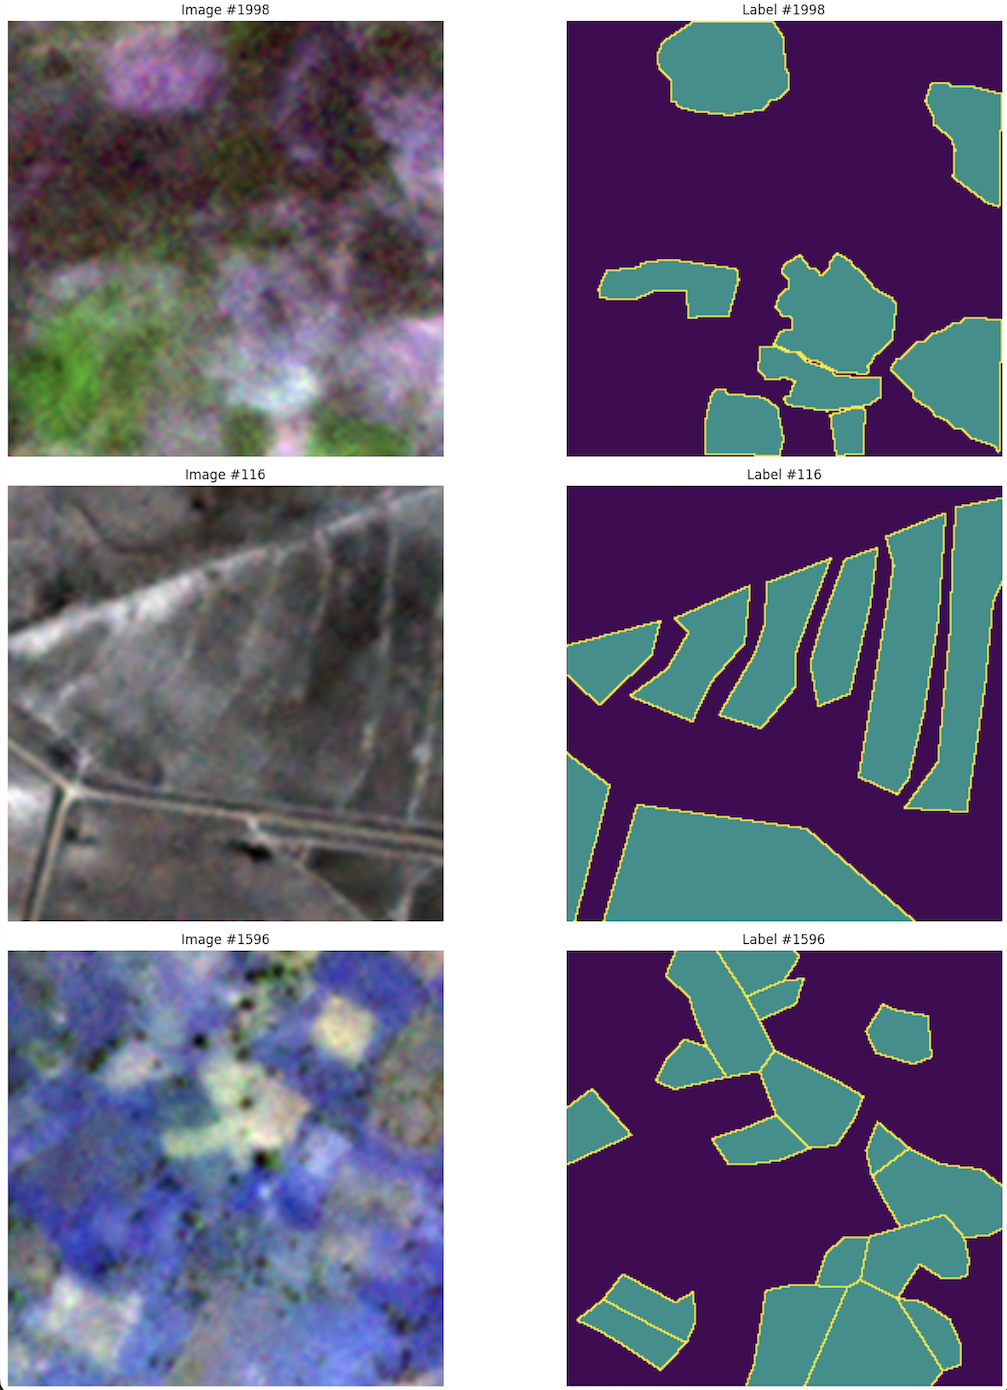